In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
np.random.seed(10)

iris = load_iris()
list(iris.keys())
print(iris.DESCR)

class SNN:
    
    def __init__(self, data, n_iterations=2000, learning_rate = 0.01):
        self.data = data
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    #function to load the data and split into features and labels          
    def load_data(self):
        iris = self.data
        df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
        df['target']= np.where(df['target'] == 0.0, 1, 0)
        X = df[iris['feature_names']].values
        y = df['target'].values
        return X,y

    #function to split data into training and test sets
    def train_test(self,X,y):
        x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)
        return x_train, x_test, y_train, y_test
        
    #function to create intial weights and bias - starting with all 0
    def initial_parameters(self,X):
        n_samples, n_features = X.shape
        theta = np.zeros(X.shape[1])
        bias = 0
        return theta, bias, n_samples

    #the sigmoid function for logistic regression
    def logit(self,x):
        return 1/(1+np.exp(-x))

    #defining our cost function
    def cost_function(self,X, y, theta, bias):
        m = len(y)
        z = np.matmul(X, theta) + bias
        h = self.logit(z)
        cost = np.square(np.subtract(y,h)).mean()
        #cost = (1/m)*(np.matmul((-y).T , np.log(h))-np.matmul((1-y).T , np.log(1-h)))
        return cost

    #the leanring schedule for stochastic and mini-batch gradient descent
    def learning_schedule(self,t0, t1, t): 
        return t0/(t+t1)
    
    #function to calculate the gradients
    def gradient(self,X, y, theta, bias,learning_rate):
        m = len(y)
        z = np.matmul(X, theta) + bias
        h = self.logit(z)
        t_gradient = 2/m * np.matmul(X.T,(h - y) )
        theta = theta - self.learning_rate * t_gradient
        b_gradient = np.mean((h - y))
        bias = bias - learning_rate * b_gradient
        return theta, bias

    #function to perform the predictions and determine how many are above and below 0.5
    #above 0.5 means predicted to be setosa, below means predicted to not be setosa
    def predict(self,X, theta, bias,threshold=0.5):
        return self.logit(np.matmul(X,theta.T) + bias) >= threshold
    
#################################################################################          

    #function for batch gradient descent
    def batch_GD(self):
        X,y = self.load_data() #load the data
        X_train, X_test, y_train, y_test = self.train_test(X,y) #split the data to traina and test
        theta, bias, n_samples = self.initial_parameters(X_train) #get initial weights and bias
        costs = []
        for i in range(self.n_iterations): # for each iterations calculate gradient and cost
            theta, bias = self.gradient(X_train, y_train, theta, bias,self.learning_rate)
            costs.append( self.cost_function(X_train, y_train, theta, bias))
            if i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, costs[i])) #keep track of costs
        print("train accuracy: {} %".format((self.predict(X_train,theta, bias) == y_train).mean()))
        print("test accuracy: {} %".format((self.predict(X_test,theta, bias) == y_test).mean()))

        return costs
        

    #function for stochastic gradient descent        
    def stochastic_GD(self,t0,t1, n_epochs):
        X,y = self.load_data()  #load the data
        X_train, X_test, y_train, y_test = self.train_test(X,y) #split the data to traina and test
        theta, bias, n_samples = self.initial_parameters(X_train) #get initial weights and bias
        m = len(y_train)
        epoch_loss = []

        for epoch in range(n_epochs): # for each epoch calculate gradient and cost for only one random instance
            for i in range(m):
                costs = []
                random_index = np.random.randint(m)
                X_instance = X_train[random_index:random_index+1]
                y_instance = y_train[random_index:random_index+1]
                theta, bias = self.gradient(X_instance, y_instance, theta, bias,self.learning_rate)
                learning_rate = self.learning_schedule(t0,t1,epoch * m + i)
                costs.append( self.cost_function(X_instance, y_instance, theta,bias))
            avg_loss = sum(costs)/len(costs) #average the costs for the m iterations for each epoch
            epoch_loss.append(avg_loss) #keep track of costs

            if epoch % 10 == 0:
                print ("Cost after epoch %epoch: %f" %(epoch, avg_loss))
        print("train accuracy: {} %".format((self.predict(X_train,theta, bias) == y_train).mean()))
        print("test accuracy: {} %".format((self.predict(X_test,theta, bias) == y_test).mean()))

        return epoch_loss

    #function for mini batch gradient descent  
    def mini_batch_GD(self,t0,t1, n_epochs):
        X,y = self.load_data() #load the data
        X_train, X_test, y_train, y_test = self.train_test(X,y) #split the data to traina and test
        theta, bias, n_samples = self.initial_parameters(X_train) #get initial weights and bias
        m = len(y_train)
        epoch_loss = []

        for epoch in range(n_epochs): # for each epoch calculate gradient and cost for only 12 random instances
            for i in range(m):
                costs = []
                random_indexes = np.random.choice(X_train.shape[0], 12, replace=False)
                X_instance = X_train[random_indexes, :]
                y_instance = y_train[random_indexes]
                theta, bias = self.gradient(X_instance, y_instance, theta, bias,self.learning_rate)
                self.learning_rate = self.learning_schedule(t0,t1,epoch * m + i)
                costs.append( self.cost_function(X_instance, y_instance, theta,bias))
            avg_loss = sum(costs)/len(costs)#average the costs for the m iterations for each epoch
            epoch_loss.append(avg_loss) #keep track of costs

            if epoch % 10 == 0:
                print ("Cost after epoch %epoch: %f" %(epoch, avg_loss))
        print("train accuracy: {} %".format((self.predict(X_train,theta, bias) == y_train).mean()))
        print("test accuracy: {} %".format((self.predict(X_test,theta, bias) == y_test).mean()))

        return epoch_loss


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [9]:
test = SNN(iris, 2000, 0.1)

Cost after iteration 0: 0.258447
Cost after iteration 100: 0.001911
Cost after iteration 200: 0.000715
Cost after iteration 300: 0.000404
Cost after iteration 400: 0.000270
Cost after iteration 500: 0.000197
Cost after iteration 600: 0.000153
Cost after iteration 700: 0.000123
Cost after iteration 800: 0.000102
Cost after iteration 900: 0.000087
Cost after iteration 1000: 0.000075
Cost after iteration 1100: 0.000065
Cost after iteration 1200: 0.000058
Cost after iteration 1300: 0.000052
Cost after iteration 1400: 0.000047
Cost after iteration 1500: 0.000042
Cost after iteration 1600: 0.000039
Cost after iteration 1700: 0.000035
Cost after iteration 1800: 0.000033
Cost after iteration 1900: 0.000030
train accuracy: 1.0 %
test accuracy: 1.0 %


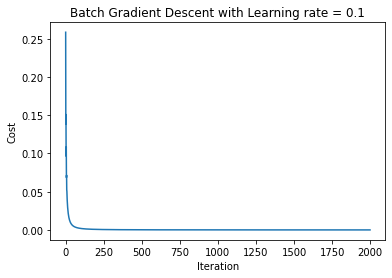

In [10]:
mse_batch = test.batch_GD()

plt.plot(mse_batch)
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.title("Batch Gradient Descent with Learning rate = 0.1")
plt.show()



Cost after epoch 0.000000e+00poch: 0.000094
Cost after epoch 1.000000e+01poch: 0.000000
Cost after epoch 2.000000e+01poch: 0.000005
Cost after epoch 3.000000e+01poch: 0.000000
Cost after epoch 4.000000e+01poch: 0.000000
train accuracy: 1.0 %
test accuracy: 1.0 %


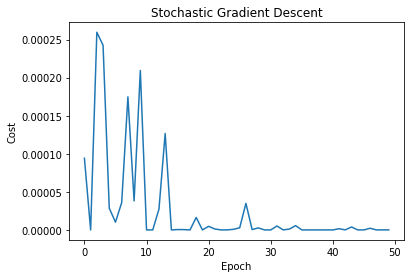

In [11]:
mse_stochastic = test.stochastic_GD(5,50,50)

plt.plot(mse_stochastic)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title("Stochastic Gradient Descent")
plt.show()



Cost after epoch 0.000000e+00poch: 0.008054
Cost after epoch 1.000000e+01poch: 0.000861
Cost after epoch 2.000000e+01poch: 0.000220
Cost after epoch 3.000000e+01poch: 0.000065
Cost after epoch 4.000000e+01poch: 0.000250
train accuracy: 1.0 %
test accuracy: 1.0 %


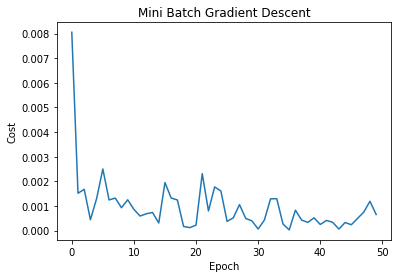

In [12]:
mse_mini_batch = test.mini_batch_GD(5,50,50)

plt.plot(mse_mini_batch)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title("Mini Batch Gradient Descent")
plt.show()